# Two-Layer Fully Connected Neural Network 

**This material is heavily based on the popular Standford CS231n lecture material.** [Please check on their website for more detailed information](https://cs231n.github.io/).

## Preparations
As usual, let's start with some preparations.

In [28]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 10,
})

from utils import *

np.set_printoptions(precision=5, suppress=True)


## Diagram of the neural network

![](./images/2fcnn.png)

## class TwoLayerNet

Here, we are using the the ScyPy instead of our previous gradient descent method. There are: `D*H+H*C+H+C` variables that we must solve. For this reasons, our vanilla gradient descent method often gives unsatisfactory results.

In [29]:
class TwoLayerNet():
    """
    A two-layer fully-connected neural network. The net has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first fully
    connected layer.

    In other words, the network has the following architecture:

    input - fully connected layer - ReLU - fully connected layer - softmax

    The outputs of the second fully-connected layer are the scores for each class.
    """


    def __init__(self, input_size, hidden_size, output_size, std=1e-5):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)


    @staticmethod
    def loss(W1, b1, W2, b2, X, Y, reg=0.0, grad=False):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - Y: Vector of training labels. Y[i] is the label for X[i], and each y[i] is
        an integer in the range 0 <= Y[i] < C. This parameter is optional; if it
        is not passed then we only return scores, and if it is passed then we
        instead return the loss and gradients.
        - reg: Regularization strength.
        - grad: flag to or NOT to return the loss gradients

        Returns:
        - loss: Loss (data loss and regularization loss) for this batch of training
        samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
        with respect to the loss function; has the same keys as self.params.
        """
        N, D = X.shape

        # Compute the forward pass
        fc1 = X.dot(W1) + b1     # fully connected
        X2 = np.maximum(0, fc1)  # ReLU
        F = X2.dot(W2) + b2 # fully connected
        
        # Compute the loss 
        F = F - np.max(F, axis=1).reshape(-1,1)
        expF = np.exp(F)
        softmax = expF/np.sum(expF, axis=1).reshape(-1,1) 
        loss = np.sum(-np.log(softmax[range(N),Y])) / N + reg  * (np.sum(W2 * W2) + np.sum( W1 * W1 ))
        
        if grad == True: # loss gradient is optionals
            # Backward pass: compute gradients
            softmax[np.arange(N) ,Y] -= 1
            softmax /= N

            # W2 gradient
            dW2 = X2.T.dot(softmax)   # [HxN] * [NxC] = [HxC]

            # b2 gradient
            db2 = softmax.sum(axis=0)

            # W1 gradient
            dW1 = softmax.dot(W2.T)   # [NxC] * [CxH] = [NxH]
            dfc1 = dW1 * (fc1>0)      # [NxH] . [NxH] = [NxH]
            dW1 = X.T.dot(dfc1)       # [DxN] * [NxH] = [DxH]

            # b1 gradient
            db1 = dfc1.sum(axis=0)

            # regularization gradient
            dW1 += reg * 2 * W1
            dW2 += reg * 2 * W2

            dW = np.hstack((dW1.flatten(), db1, dW2.flatten(), db2))
        
            return (loss, dW)
        
        return loss


    def train(self, X, Y, reg=1e-5, gtol=1e-5, maxiter=1000, verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
        X[i] has label c, where 0 <= c < C.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - verbose: boolean; if true print progress during optimization.
        """
        self.params["loss_history"] = []

        D, H = self.params['W1'].shape
        H, C = self.params['W2'].shape

        def obj(x):
            W1 = x[0: D*H].reshape(D,H)
            b1 = x[D*H: D*H+H]
            W2 = x[D*H+H: D*H+H+(H*C)].reshape(H,C)
            b2 = x[D*H+H+(H*C):]

            loss = self.loss(W1, b1, W2, b2, X, Y, reg=reg, grad=True)
            self.params["loss_history"].append(loss[0])

            if verbose == True:
                print(loss)

            return loss

        x0 = np.hstack((self.params['W1'].flatten(), 
                        self.params['b1'], 
                        self.params['W2'].flatten(), 
                        self.params['b2']))
        res = minimize(obj, x0, method='L-BFGS-B', jac=True, options={'gtol': gtol, 'maxiter': maxiter, 'disp': True})

        self.params["W1"] = res.x[0: D*H].reshape(D,H)
        self.params["b1"] = res.x[D*H: D*H+H]
        self.params["W2"] = res.x[D*H+H: D*H+H+(H*C)].reshape(H,C)
        self.params["b2"] = res.x[D*H+H+(H*C):]
    

    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
        classify.

        Returns:
        - Y_pred: A numpy array of shape (N,) giving predicted labels for each of
        the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
        to have class c, where 0 <= c < C.
        """

        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        # Compute the forward pass
        fc1 = X.dot(W1) + b1     # fully connected
        X2 = np.maximum(0, fc1)  # ReLU
        scores = X2.dot(W2) + b2 # fully connected
    
        y_pred = np.argmax( scores, axis=1)
        
        return y_pred

## Example 1: Breast Cancer Wisconsin

https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

Load training and test dataset:

In [30]:
data = np.loadtxt("./datasets/breast_cancer/wdbc.data", delimiter=",", dtype=str)
X = np.float32(data[:, 2:12])  # 10 dimensions

# Diagnosis (M = malignant, B = benign)
Y = np.zeros(X.shape[0], dtype=np.int32) 
Y[np.where(data[:,1]=='M')] = 1
Y[np.where(data[:,1]=='B')] = 0

print("Dimension numbers :", X.shape[1])
print("Number of data    :", X.shape[0])
print("Labels            :", np.unique(Y))

# For the NN
input_size  = X.shape[1]
num_classes = len(np.unique(Y))

Dimension numbers : 10
Number of data    : 569
Labels            : [0 1]


Split the data into train and test datasets:

In [31]:
X_train = X[0:400, :]
Y_train = Y[0:400]
X_test  = X[401:, :]
Y_test  = Y[401:]

num_test = X_test.shape[0]

These are some hyperparameters that we need to tune. A new parameter called: hidden_size descirbes how many neurons in the hidden layer.

```python 
hidden_size = 100 # Try 20, 25, 50, 100
learning_rate = 1e-4 # Try 1e-5, 1e-4
reg = 0.01 # Try 0.1, 0.01. 0.001. 0.0001, 0
```

In [32]:
hidden_size = 20

net = TwoLayerNet(input_size, hidden_size, num_classes)
stats = net.train(X_train, Y_train, reg=0.001, gtol=0.001, maxiter=100, verbose=False)

# Predict on the validation set
train_acc = (net.predict(X_train) == Y_train).mean()
print('Training accuracy   : ', train_acc)

# Predict on the validation set
val_acc = (net.predict(X_test) == Y_test).mean()
print('Validation accuracy : ', val_acc)

Training accuracy   :  0.9175
Validation accuracy :  0.8630952380952381


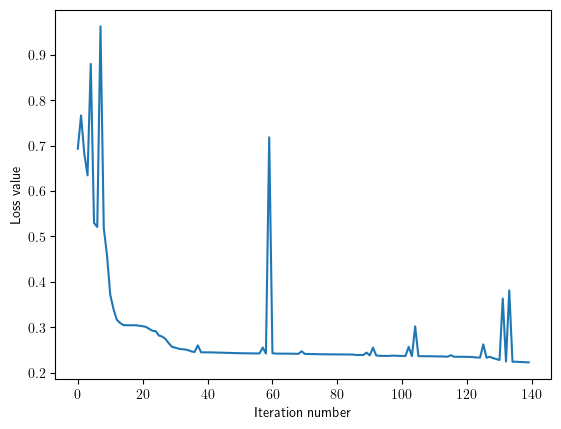

In [33]:
plt.plot(net.params["loss_history"])
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

----

## Example 2: Handwritten Digits

This dataset is publicly available and can be downloaded from [this link](https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits).

Let us start with the train dataset:

In [34]:
data = np.loadtxt("./datasets/handwritten_digits/optdigits.tra", delimiter=",", dtype=int)
X_train = np.int32(data[:, 0:-1])  
Y_train = np.int32(data[:, -1]) 


print("Dimension numbers :", X_train.shape[1])
print("Number of data    :", X_train.shape[0])
print("Labels            :", np.unique(Y_train))

# For the NN
input_size  = X_train.shape[1]
num_classes = len(np.unique(Y_train))

Dimension numbers : 64
Number of data    : 3823
Labels            : [0 1 2 3 4 5 6 7 8 9]


In [35]:
data = np.loadtxt("./datasets/handwritten_digits/optdigits.tes", delimiter=",", dtype=int)
X_test = np.int32(data[:, 0:-1])  
Y_test = np.int32(data[:, -1]) 

print("Dimension numbers :", X_test.shape[1])
print("Number of data    :", X_test.shape[0])
print("Labels            :", np.unique(Y_test))

Dimension numbers : 64
Number of data    : 1797
Labels            : [0 1 2 3 4 5 6 7 8 9]


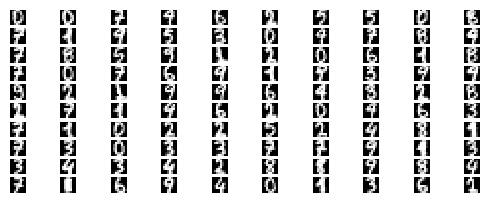

In [36]:
for i in range(100):
    X_train_ = X_train[i,:].reshape(8, 8)
    X_train_ = np.abs(255.0 - 255.0 / 16.0 * X_train_)
    plt.subplot(20, 10, i + 1)
    # Rescale the weights to be between 0 and 255
    plt.imshow(X_train_.astype('uint8'), cmap='Greys')
    plt.axis('off')

Now, let us setup and then train the neural network.

In [ ]:
hidden_size = 100

net = TwoLayerNet(input_size, hidden_size, num_classes)
stats = net.train(X_train, Y_train, reg=0.1, gtol=1e-3, maxiter=100, verbose=False)

Next, we check the accuray for training and test dataset.

In [ ]:
# Predict on the validation set
train_acc = (net.predict(X_train) == Y_train).mean()
print('Training accuracy : ', train_acc)

# Predict on the test set
test_acc = (net.predict(X_test) == Y_test).mean()
print('Test accuracy     : ', test_acc)

Training accuracy :  0.9659952916557677
Test accuracy     :  0.9432387312186978


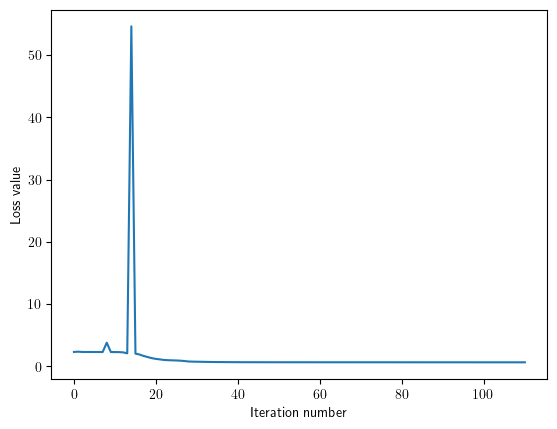

In [ ]:
plt.plot(net.params["loss_history"])
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()